In [71]:
import os
import json
import subprocess
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [72]:
def read_dmat(file):
    h = np.loadtxt(file, max_rows=1, usecols=[0,1], dtype=np.int32)
    A = np.loadtxt(file, skiprows=1, usecols=[0], dtype=np.float32)
    A = np.reshape(A,(h[0],h[1]))
    return A

In [73]:
from dataclasses import dataclass, field

@dataclass
class Config:
    name: str
    tol: float = 1e-2
    kappa: float = 4e9
    solver: str = 'pcg-IC'
    mixed_vars: list = field(default_factory=lambda: ["mixed-stretch", "mixed-collision"])
    unmixed_vars: list = field(default_factory=lambda: [])
    dhat: float = 0.005

In [74]:
kappa = 1e8
dhat = 0.005
solver = 'pcr-bj'
configs = [Config('FEM-pcg-ic-1e-1',1e-1, kappa,solver,[],['stretch','collision']),
           Config('FEM-pcg-ic-1e-2',1e-2, kappa,solver,[],['stretch','collision']),
           Config('FEM-pcg-ic-1e-3',1e-3, kappa,solver,[],['stretch','collision']),
           Config('FEM-cholmod',1e-8, kappa, 'cholmod',[],['stretch','collision']),
           Config('MFEM-pcg-ic-1e-1',1e-1, kappa,solver,['mixed-stretch','mixed-collision'],[]),
           Config('MFEM-pcg-ic-1e-2',1e-2, kappa,solver,['mixed-stretch','mixed-collision'],[]),
           Config('MFEM-pcg-ic-1e-3',1e-3, kappa,solver,['mixed-stretch','mixed-collision'],[]),
           Config('MFEM-cholmod',1e-8, kappa, 'cholmod',['mixed-stretch','mixed-collision'],[])
          ]

configs = [
           Config('FEM-cholmod',1e-8, kappa, 'cholmod',[],['stretch','collision']),
           #Config('MFEM-Stretch-cholmod',1e-8, kappa, 'cholmod',['mixed-stretch'],['collision']),
           #Config('MixedColl-cholmod',1e-8, kappa, 'cholmod',['mixed-collision'],['stretch']),
           Config('MFEM-cholmod',1e-8, kappa, 'cholmod',['mixed-stretch','mixed-collision'],[])
          ]

In [75]:
ROOT = os.getcwd() + '/../'
exe_path = os.path.join(ROOT,'build/bin/convergence')
scene_path = os.path.join(ROOT,'scenes/2D/')
scene_name = 'diving_board_deformed.json'
#scenes = ['soft_blocks.json']

In [76]:
# Load in the json file for the current scene
scene_file = os.path.join(scene_path,scene_name)
with open(scene_file, 'r') as f:
    scene_json = json.load(f);

In [90]:
A = []
B = []
tmp_json = 'tmp.json'
timesteps = 60      # number of timesteps to run each trial for
newton_iters = 100

for (i,config) in enumerate(configs):    
    # Modify scene description
    scene_json['dhat'] = config.dhat
    scene_json['kappa'] = config.kappa
    scene_json['linear_solver'] = config.solver
    scene_json['variables'] = config.unmixed_vars
    scene_json['mixed_variables'] = config.mixed_vars
    scene_json['max_newton_iterations'] = newton_iters
    scene_json['iterative_solver_tolerance'] = config.tol
    print('mixed', config.mixed_vars, ' variables', config.unmixed_vars, ' tol: ', config.tol)
    
    # Write current modified json to tmp file
    with open(tmp_json, 'w') as f:
        json.dump(scene_json, f, indent=4)
    
    # Run simulation
    ret=subprocess.run([exe_path,tmp_json,'-n',str(timesteps)],
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    # Add data
    data = os.path.join(ROOT,'output/convergence.dmat')
    data = read_dmat(data)
    B.append(data)
    data = np.mean(data,axis=1)
    A.append(data)

mixed []  variables ['stretch', 'collision']  tol:  1e-08
mixed ['mixed-stretch', 'mixed-collision']  variables []  tol:  1e-08


In [101]:
print(B[0].shape)
A_max = [] 
A_min = []
A_mean = []
beg = 3
end = 13
for i in range(len(B)):
    A_max.append(np.max(B[i][:,beg:end],axis=1))
    A_min.append(np.min(B[i][:,beg:end],axis=1))
    A_mean.append(np.mean(B[i][:,beg:end],axis=1))
print(len(A_max))

(100, 60)
2


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


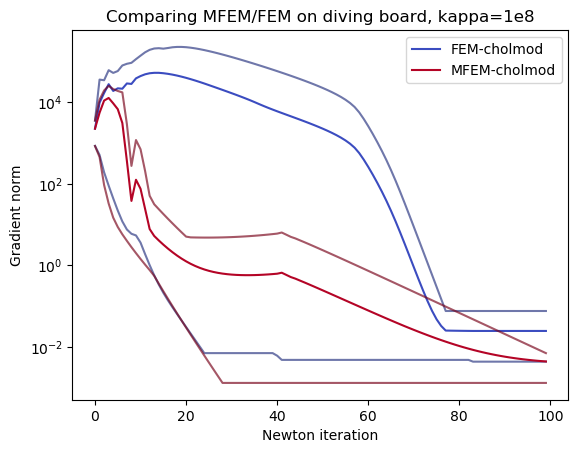

In [102]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(A)))

linestyles =['-']
markers=['.','x','v']
markevery=[5,5,5]

for i in range(len(A)):
    xsize = len(A_mean[i])
    plt.plot(np.arange(0,xsize),A_max[i],color=colors[i]/1.5)#,linestyle='dashed')
    plt.plot(np.arange(0,xsize),A_min[i],color=colors[i]/1.5)#,linestyle='dashed')
    p = plt.plot(np.arange(0,xsize),A_mean[i],color=colors[i],
                 linestyle=linestyles[i%len(linestyles)])
    
# for i in range(len(A)):
#     p = plt.plot(np.arange(0,len(A[i])),A[i],color=colors[i])#,
#                  linestyle=linestyles[i%len(linestyles)],
#                  marker=markers[i%len(markers)],
#                  markevery=markevery[i%len(markevery)])
    p[0].set_label(configs[i].name)

plt.xlabel('Newton iteration')
plt.ylabel('Gradient norm')
plt.yscale('log')    
plt.title('Comparing MFEM/FEM on diving board, kappa=1e8')
plt.legend(loc='upper right')
plt.savefig('mfem-fem-diving_board.eps', format='eps')
plt.show()


(300, 60)


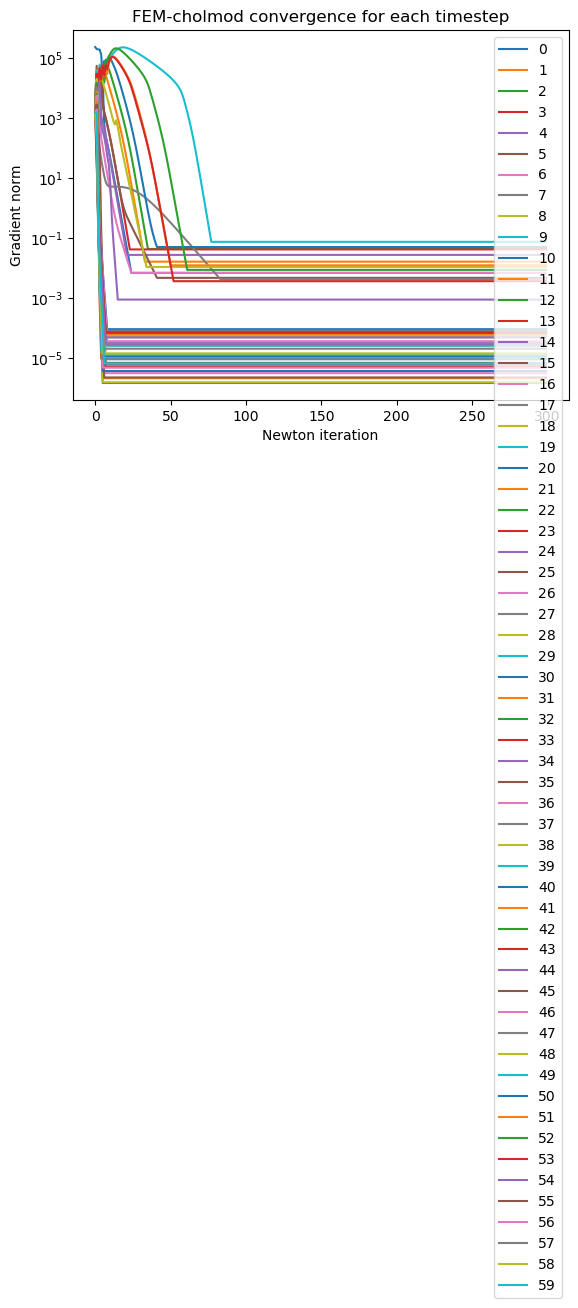

[[2.3680522e+05 3.5296335e+03 3.5261323e+03 ... 1.4650302e+03
  1.4886538e+03 1.4850286e+03]
 [2.0260828e+05 1.2962699e+04 1.0317608e+04 ... 2.6417197e+02
  2.8922321e+02 1.6007062e+03]
 [1.9762653e+05 1.9712818e+04 1.8752838e+04 ... 7.4228132e-01
  7.1375322e-01 4.0639973e-01]
 ...
 [6.9030081e-03 1.6342953e-02 4.3416481e-02 ... 9.0586946e-06
  1.4035935e-05 6.6258858e-06]
 [6.9030081e-03 1.6342953e-02 4.3416481e-02 ... 9.0586946e-06
  1.4035935e-05 6.6258858e-06]
 [6.9030081e-03 1.6342953e-02 4.3416481e-02 ... 9.0586946e-06
  1.4035935e-05 6.6258858e-06]]


In [81]:
idx = 0
niters = 10

data = B[idx]
print(data.shape)
for i in range(min(data.shape[1],niters)):
    #if (i < 30):
    #    continue;
    plt.plot(np.arange(0,data.shape[0]), data[:,i])
    plt.xlabel('Newton iteration')
    plt.ylabel('Gradient norm')
    plt.yscale('log')
#plt.legend(tolerances)
plt.title(str(configs[idx].name) + ' convergence for each timestep')
plt.legend(np.arange(0,min(data.shape[1],niters)))
plt.show()
print(data)

In [10]:
os.remove(tmp_json)

## Soft block convergence

In [103]:
# Load in the json file for the current scene
scene_file = os.path.join(scene_path,'soft_blocks_drop.json')
#scene_file = os.path.join(scene_path,'soft_blocks.json')
with open(scene_file, 'r') as f:
    scene_json = json.load(f);

In [104]:
# dhats = np.linspace(0.001, 0.0001, 5)
# dhats2 = np.array([0.005, 0.001, 0.0001, 0.000075])#, 0.000075, 0.00005])
# dhats = np.concatenate((dhats, dhats2))
# dhats = dhats2
# #dhats = np.arange
# print(dhats)

In [105]:
kappa = 1e10
dhats = [0.004, 0.002, 0.001]
dhats = [0.001]
configs = []
for dhat in dhats:
    configs.append(Config('FEM-dhat-' + str(dhat),
                          0, kappa, 'cholmod',[],
                          ['stretch','collision'],dhat))
for dhat in dhats:
    configs.append(Config('MFEM-cholmod-' + str(dhat),
                          0, kappa, 'cholmod',
                          ['mixed-stretch','mixed-collision'],[],dhat))

In [109]:
A = []
B = []
tmp_json = 'tmp.json'
timesteps = 40 # number of timesteps to run each trial for
newton_iters = 1500

for (i,config) in enumerate(configs):    
    # Modify scene description
    print(config.dhat)
    scene_json['dhat'] = config.dhat
    scene_json['kappa'] = config.kappa
    scene_json['linear_solver'] = config.solver
    scene_json['variables'] = config.unmixed_vars
    scene_json['mixed_variables'] = config.mixed_vars
    scene_json['max_newton_iterations'] = newton_iters
    print('mixed', config.mixed_vars, ' variables', config.unmixed_vars, ' tol: ', config.tol)
    
    # Write current modified json to tmp file
    with open(tmp_json, 'w') as f:
        json.dump(scene_json, f, indent=4)

    # Run simulation
    ret=subprocess.run([exe_path,tmp_json,'-n',str(timesteps)],
                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    
    # Add data
    data = os.path.join(ROOT,'output/convergence.dmat')
    data = read_dmat(data)
    B.append(data)
    data = np.mean(data,axis=1)
    A.append(data)

0.001
mixed []  variables ['stretch', 'collision']  tol:  0
0.001
mixed ['mixed-stretch', 'mixed-collision']  variables []  tol:  0


In [119]:
print(B[0].shape)
A_max = [] 
A_min = []
A_mean = []
beg = 30
end = 40
for i in range(len(B)):
    A_max.append(np.max(B[i][:,beg:end],axis=1))
    A_min.append(np.min(B[i][:,beg:end],axis=1))
    A_mean.append(np.mean(B[i][:,beg:end],axis=1))
print(len(A_max))

(1500, 40)
2


No handles with labels found to put in legend.


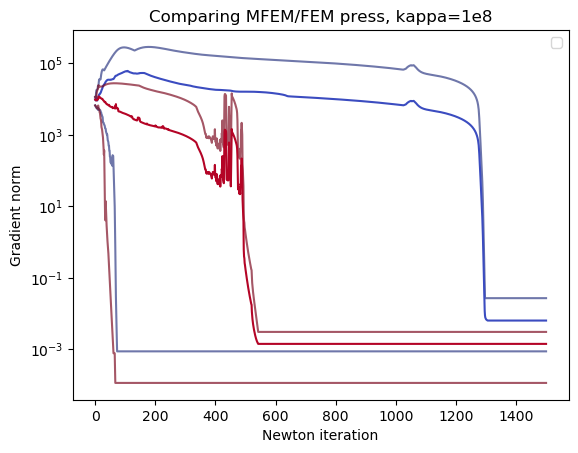

In [120]:
colors = plt.cm.coolwarm(np.linspace(0,1,len(A)))

linestyles =['-']
markers=['o','^','s']
markevery=[10,10,10]


for i in range(len(A)):
    xsize = len(A_mean[i])
    plt.plot(np.arange(0,xsize),A_max[i],color=colors[i]/1.5)#,linestyle='dashed')
    plt.plot(np.arange(0,xsize),A_min[i],color=colors[i]/1.5)#,linestyle='dashed')
    p = plt.plot(np.arange(0,xsize),A_mean[i],color=colors[i],
                 linestyle=linestyles[i%len(linestyles)])#,
#                  marker=markers[i%len(markers)],
#                  markevery=markevery[i%len(markevery)])
    #p[0].set_label(configs[i].name)
#plt.xscale('log') 

plt.xlabel('Newton iteration')
plt.ylabel('Gradient norm')
plt.yscale('log')    
plt.title('Comparing MFEM/FEM press, kappa=1e8')
plt.legend(loc='upper right')
#plt.savefig('mfem-fem-0.001.eps', format='eps')
plt.show()


No handles with labels found to put in legend.


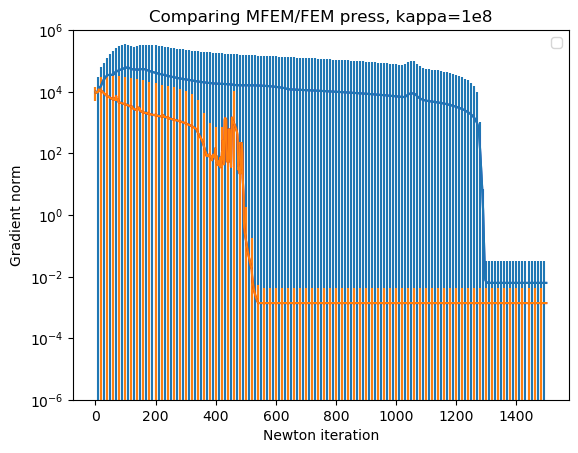

In [126]:
# Error bar plot instead
colors = plt.cm.coolwarm(np.linspace(0,1,len(A)))

linestyles =['-']
markers=['o','^','s']
markevery=[10,20,10]


for i in range(len(A)):
    xsize = len(A_mean[i])
    err = A_max[i] - A_min[i]
    plt.errorbar(np.arange(0,xsize),A_mean[i],yerr=err, errorevery=markevery[i])
    p = plt.plot(np.arange(0,xsize),A_mean[i],color=colors[i],
                 linestyle=linestyles[i%len(linestyles)])#,
#                  marker=markers[i%len(markers)],
#                  markevery=markevery[i%len(markevery)])
    #p[0].set_label(configs[i].name)
#plt.xscale('log') 

plt.xlabel('Newton iteration')
plt.ylabel('Gradient norm')
plt.yscale('log')
plt.ylim([1e-6,1e6])
plt.title('Comparing MFEM/FEM press, kappa=1e8')
plt.legend(loc='upper right')
#plt.savefig('mfem-fem-0.001.eps', format='eps')
plt.show()

(2000, 40)


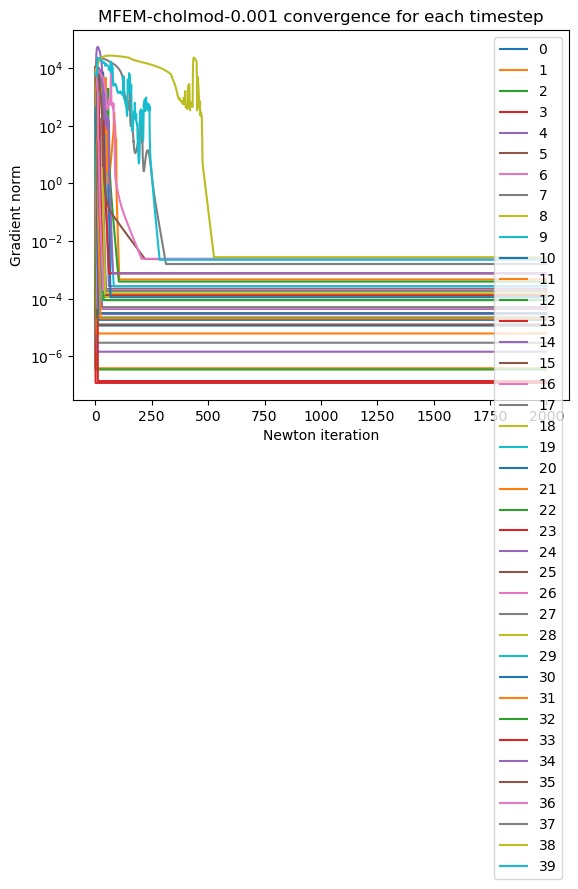

[[1.7602744e+02 4.6823999e+02 8.1941998e+02 ... 8.3466641e+03
  7.2405986e+03 6.6328682e+03]
 [1.5322441e-05 3.7702927e-07 3.4108845e-07 ... 7.7983052e+03
  7.0461865e+03 6.4108213e+03]
 [1.1491967e-05 3.7702927e-07 3.4108845e-07 ... 8.8312812e+03
  7.3403228e+03 6.4817095e+03]
 ...
 [1.1491967e-05 3.7702927e-07 3.4108845e-07 ... 1.5844133e-03
  2.7401953e-03 2.2280766e-03]
 [1.1491967e-05 3.7702927e-07 3.4108845e-07 ... 1.5844133e-03
  2.7401953e-03 2.2280766e-03]
 [1.1491967e-05 3.7702927e-07 3.4108845e-07 ... 1.5844133e-03
  2.7401953e-03 2.2280766e-03]]


In [17]:
idx = 1
niters = 50

data = B[idx]
print(data.shape)
for i in range(min(data.shape[1],niters)):
#     if (i < 35):
#        continue;
    plt.plot(np.arange(0,data.shape[0]), data[:,i])
    plt.xlabel('Newton iteration')
    plt.ylabel('Gradient norm')
    plt.yscale('log')
#plt.legend(tolerances)
plt.title(str(configs[idx].name) + ' convergence for each timestep')
plt.legend(np.arange(0,min(data.shape[1],niters)))
plt.show()
print(data)